# Binary Classification of Cats and Dogs Images

## Preprocessing

In [11]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Importing data
ds_train = image_dataset_from_directory(
    'train',
    labels='inferred',
    label_mode = 'binary',
    interpolation='nearest',
    image_size = [128,128],
    batch_size=64,
)

ds_valid = image_dataset_from_directory(
    'test',
    labels='inferred',
    label_mode = 'binary',
    interpolation='nearest',
    image_size = [128,128],
    batch_size=64 
)

Found 557 files belonging to 2 classes.
Found 140 files belonging to 2 classes.


### Visualization

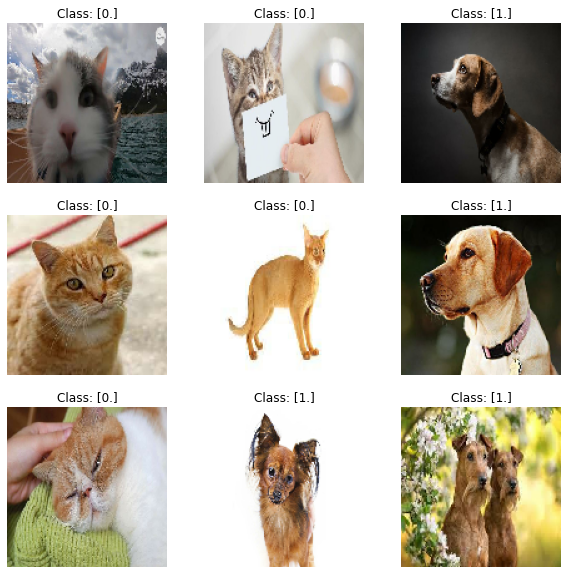

In [12]:
import matplotlib.pyplot as plt

# Selecting images and their respective labels
for images,labels in ds_train.take(1):

    # Creating figure of 10x10 (inches)
    plt.figure(figsize=(10,10))

    # Itering through images and plotting them
    ## uint8 ensures treatment as 8-bit integers
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(f"Class: {labels[i].numpy()}")
        plt.axis('off')

    plt.show()



## Data Preparation

In [13]:
# Defining function for treating images as float data
def convert_to_float(image,label):
    image = tf.image.convert_image_dtype(image,dtype=tf.float32)
    return image,label

# Optimizing CPU usage
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Converting images
## Storing data in cache memory
### Optimizing data availabilty
ds_train = (
    ds_train.map(convert_to_float).cache().prefetch(buffer_size = AUTOTUNE)
)

ds_valid = (
    ds_valid.map(convert_to_float).cache().prefetch(buffer_size = AUTOTUNE)
)

## Architecture of the Convolutional Neural Network

In [14]:
from keras.applications import DenseNet121

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

In [15]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.optimizers.schedules import ExponentialDecay
from keras.applications import DenseNet121

early_stopping = EarlyStopping(
    min_delta=0.01,
    patience=100,
    restore_best_weights=True
)

reduce_learning_rate = ReduceLROnPlateau(
    monitor='binary_accuracy',
    patience=100,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

learning_rate_schedule = ExponentialDecay(
    initial_learning_rate = 0.01,
    decay_steps = 1000,
    decay_rate=0.5
)

lr_callback = LearningRateScheduler(learning_rate_schedule)
callback = [lr_callback, reduce_learning_rate, early_stopping]

for layer in base_model.layers:
    layer.trainable = False

# Defining the model
model = Sequential()

model.add(base_model),

model.add(Flatten()),

model.add(Flatten())

model.add(Dense(256, activation='relu'))

model.add(Dense(128, activation='relu'))

model.add(Dense(64, activation='relu'))

model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 flatten_2 (Flatten)         (None, 16384)             0         
                                                                 
 flatten_3 (Flatten)         (None, 16384)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               4194560   
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)               

## Model Compilation

In this section, the model is compiled using the Adam optimizer for it being based on stochastic gradient descent algorithms, while its loss function is set to follow a binary crossentropy algorithm, which is optimal for binary classification task. Finally, in order to mensurate the model's accuracy, binary accuracy metric is implemented also for it being optimal for the present task.

In [16]:
from keras.callbacks import ModelCheckpoint

# Compiling model
model.compile(
    optimizer = Adam(learning_rate=learning_rate_schedule),
    loss='binary_crossentropy',
    metrics = ['binary_accuracy']
)

# Fitting model
history = model.fit(
    ds_train,
    validation_data = ds_valid,
    epochs = 500,
    verbose=1,
    callbacks = [callback]
)

Epoch 1/500
9/9 [==============================] - 23s 2s/step - loss: 27.5138 - binary_accuracy: 0.6517 - val_loss: 4.2007 - val_binary_accuracy: 0.8071 - lr: 0.0099
Epoch 2/500
9/9 [==============================] - 15s 2s/step - loss: 2.9691 - binary_accuracy: 0.8779 - val_loss: 4.2927 - val_binary_accuracy: 0.7857 - lr: 0.0099
Epoch 3/500
9/9 [==============================] - 15s 2s/step - loss: 0.3855 - binary_accuracy: 0.9120 - val_loss: 0.2490 - val_binary_accuracy: 0.8714 - lr: 0.0098
Epoch 4/500
9/9 [==============================] - 15s 2s/step - loss: 0.1821 - binary_accuracy: 0.8995 - val_loss: 0.3186 - val_binary_accuracy: 0.8643 - lr: 0.0098
Epoch 5/500
9/9 [==============================] - 15s 2s/step - loss: 0.1406 - binary_accuracy: 0.9318 - val_loss: 0.3958 - val_binary_accuracy: 0.8643 - lr: 0.0097
Epoch 6/500
9/9 [==============================] - 15s 2s/step - loss: 0.1351 - binary_accuracy: 0.9336 - val_loss: 0.3717 - val_binary_accuracy: 0.8643 - lr: 0.0096
Epo

In [17]:
# checkpoint = ModelCheckpoint(
#     'best_model_weights.h5',
#     monitor='binary_accuracy',
#     save_best_only=True,
#     mode='max',
#     verbose=1
# )

# # Fitting model
# history = model.fit(
#     ds_train,
#     validation_data = ds_valid,
#     epochs = 10,
#     verbose=1,
#     callbacks = [checkpoint]
# )

## Visualizing Results

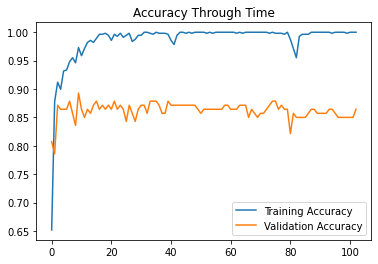

In [18]:
# Gráfico para visualizar os erros e accuracy
history.history.keys()
#evolução do erro, azul
plt.plot(history.history['binary_accuracy'],label='Training Accuracy')
#performance da rede
plt.plot(history.history['val_binary_accuracy'],label='Validation Accuracy')
plt.title('Accuracy Through Time')
plt.legend()

In [21]:
test_loss, test_acc = model.evaluate(ds_valid, verbose=1)

3/3 [==============================] - 3s 802ms/step - loss: 0.2490 - binary_accuracy: 0.8714


In [22]:
print(f'Acurácia: {test_acc} - Perda: {test_loss}')

Acurácia: 0.8714285492897034 - Perda: 0.2490101456642151
